In [26]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Aug 29 09:18:46 2019

@author: hurenjie
"""

#%%
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsClassifier

from sklearn import tree
import graphviz 
from sklearn.tree import DecisionTreeClassifier
import mglearn
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings

seed = 42

In [27]:
#%%
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

# setup marker generator and color map 
    markers = ('s', 'x', 'o', '^', 'v') 
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan') 
    cmap = ListedColormap(colors[:len(np.unique(y))])

# plot the decision surface 
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1 
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape) 
    plt.figure(figsize = (10, 8))
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap) 
    plt.xlim(xx1.min(), xx1.max()) 
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1], 
                    alpha=0.8, 
                    c=colors[idx], 
                    marker=markers[idx], 
                    label=cl,
                    edgecolor='black')

# highlight test samples 
        if test_idx:

# plot all samples 
            X_test, y_test = X[test_idx, :], y[test_idx]

            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='', 
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1, 
                        marker='o',
                        s=100, 
                        label='test set')

# 数据预处理

In [28]:
#%%
warnings.filterwarnings('ignore')
data_path = '/Users/hurenjie/Desktop/同梁志能/Code/机器学习'

df = pd.read_csv(data_path + '/IF000_5分钟_长数据.csv', 
                 header = None, 
                 names = ['date','open', 'high', 'low', 'close', 'volume', 'open interest'],
                 parse_dates = True,
                 index_col = 0)
ave = df['close'].rolling(22).mean()
bias = (df['close']-ave)/ave
df['bias'] = bias

df['atr'] = talib.ATR(df.high,df.low,df.close, timeperiod=22)

df_close_diff = df['close'].diff()
movement = [1 if i>0 else 0 for i in df_close_diff]
df['movement'] = movement

df = df[['close', 'volume', 'open interest', 'movement','bias', 'atr']]
df['close'] = df['close'].shift(-1)
df['movement'] = df['movement'].shift(-1)
#%%
df['ma5'] = df['close'].rolling(5).apply(np.mean)
df['ma20'] = df['close'].rolling(20).apply(np.mean)
#df['ma60'] = df['close'].rolling(60).apply(np.mean)
#df['ma120'] = df['close'].rolling(120).apply(np.mean)
#df['ma240'] = df['close'].rolling(240).apply(np.mean)

df['ema5'] = df['close'].ewm(span=30, min_periods = 5).mean()
df['ema20'] = df['close'].ewm(span=30, min_periods = 20).mean()
#df['ema60'] = df['close'].ewm(span=30, min_periods = 60).mean()
#df['ema120'] = df['close'].ewm(span=30, min_periods = 120).mean()
#df['ema240'] = df['close'].ewm(span=30, min_periods = 240).mean()

macd, macdsignal, macdhist = talib.MACD(df['close'], 
                                fastperiod=12, 
                                slowperiod=26, 
                                signalperiod=9)
df['macd'] = macd

df = df.dropna(how = 'any')
#%%
X = df[['macd', 'bias']]
y = df['movement']

X_train = X.loc['2017-08-22 14:50:00':'2019-07-22 14:50:00']
X_test = X.loc['2019-07-22 14:55:00':]
y_train = y.loc['2017-08-22 14:50:00':'2019-07-22 14:50:00']
y_test = y.loc['2019-07-22 14:55:00':]

scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X))
X_std.columns = X.columns
X_std.index = X.index
X_train_std = pd.DataFrame(scaler.fit_transform(X_train))
X_train_std.columns = X_train.columns
X_train_std.index = X_train.index
X_test_std = pd.DataFrame(scaler.fit_transform(X_test))
X_test_std.columns = X_test.columns
X_test_std.index = X_test.index

# 模型拟合

## KNN

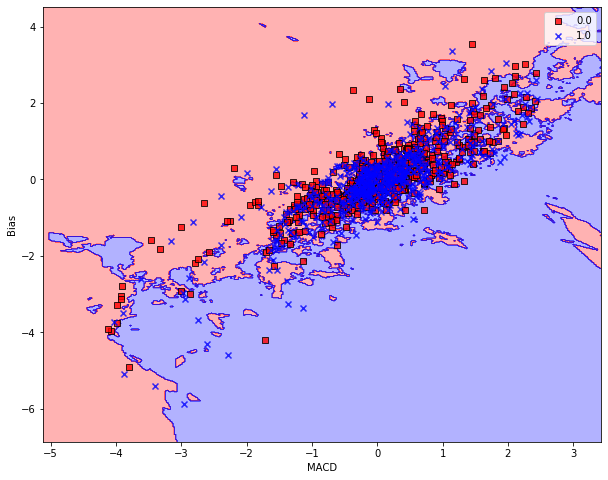

Best KNN score:
0.509963768115942





In [29]:
knn = KNeighborsClassifier(weights = 'uniform')
params = {'n_neighbors':list(range(1,21))}

searcher = GridSearchCV(knn, params, cv = 5)

searcher.fit(X_train_std, y_train)

best_knn_estimator = searcher.best_estimator_


plot_decision_regions(np.array(X_test_std), np.array(y_test), best_knn_estimator)
plt.xlabel('MACD')
plt.ylabel('Bias')
plt.legend(loc = 'upper right')
plt.show()

print('Best KNN score:\n{}'.format(best_knn_estimator.score(X_test_std, y_test)) + 
      '\n\n\n')


## Decision Tree

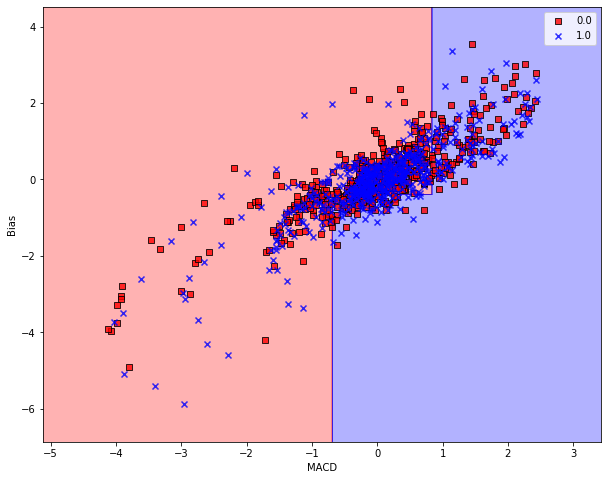

Best Decision Tree score:
0.5081521739130435





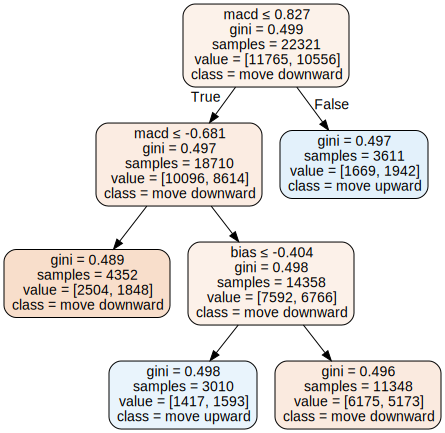

In [32]:
dt = DecisionTreeClassifier(random_state = seed)
params = {'max_depth':np.linspace(2,10,9, endpoint = True),
          'min_samples_split':np.linspace(0.1, 1, 10, endpoint = True),
          'min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint = True),
          'max_features':list(range(1, X.shape[1]))}

searcher = GridSearchCV(dt, params, cv = 5)
searcher.fit(X_train_std, y_train)
best_dt_estimator = searcher.best_estimator_

best_dt_estimator.fit(X_train_std, y_train)
#mglearn.plots.plot_tree_partition(X,y, best_dt_estimator)

plot_decision_regions(np.array(X_test_std),np.array(y_test),best_dt_estimator)
plt.xlabel('MACD')
plt.ylabel('Bias')
plt.legend(loc = 'upper right')
plt.show()
print('Best Decision Tree score:\n{}'.format(best_dt_estimator.score(X_test_std, y_test)) + '\n\n\n')

    best_dt_estimator.fit(X_train_std, y_train)

    tree_data = tree.export_graphviz(best_dt_estimator, out_file = None,
                                     max_depth = 6,
                                     feature_names = X_test.columns,
                                     class_names = ['move downward', 'move upward'],
                                     filled=True, rounded=True,  
                                     special_characters=True)

    treegraph = graphviz.Source(tree_data)

    treegraph

## Random Forest

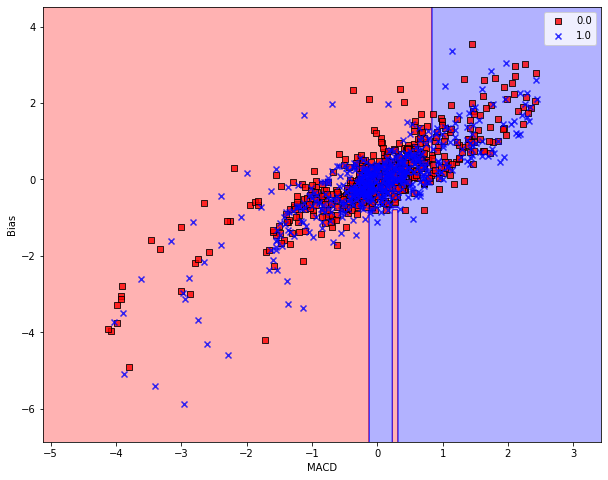

Best Random Forest score:
0.5144927536231884





In [33]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
params = {'max_depth':np.linspace(2,10,9, endpoint = True),
          'min_samples_split':np.linspace(0.1, 1, 10, endpoint = True),
          'min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint = True),
          'max_features':list(range(1, X.shape[1]))}

searcher = GridSearchCV(rf, params, cv=5)
searcher.fit(X_train_std, y_train)
best_rf_estimator = searcher.best_estimator_

best_rf_estimator.fit(X_train_std, y_train)
plot_decision_regions(np.array(X_test_std), np.array(y_test), best_rf_estimator)
plt.xlabel('MACD')
plt.ylabel('Bias')
plt.legend(loc = 'upper right')
plt.show()
print('Best Random Forest score:\n{}'.format(best_rf_estimator.score(X_test_std, y_test)) + '\n\n\n')

## SVM

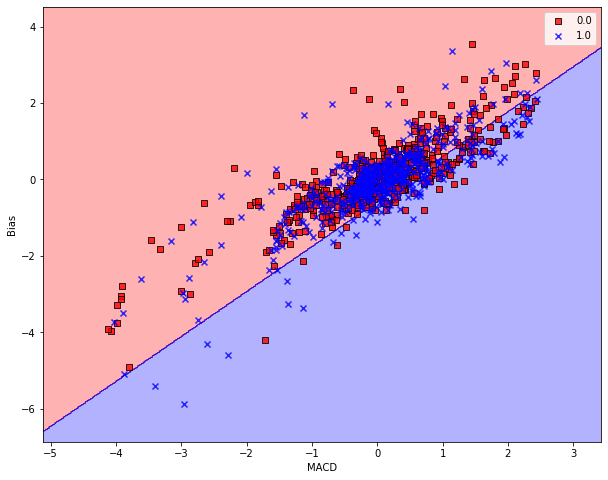

linear score:
0.5289855072463768





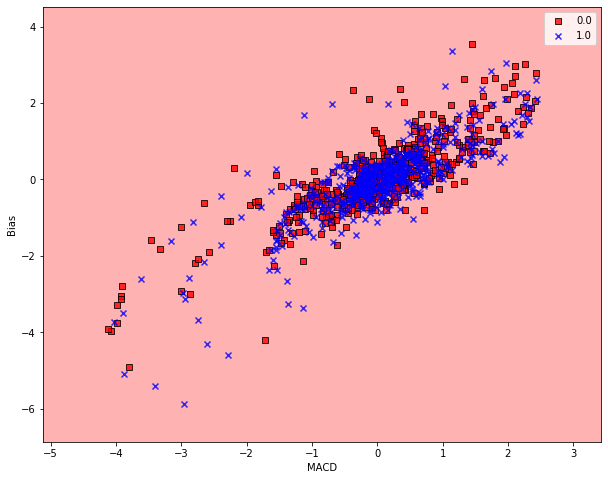

poly score:
0.5144927536231884





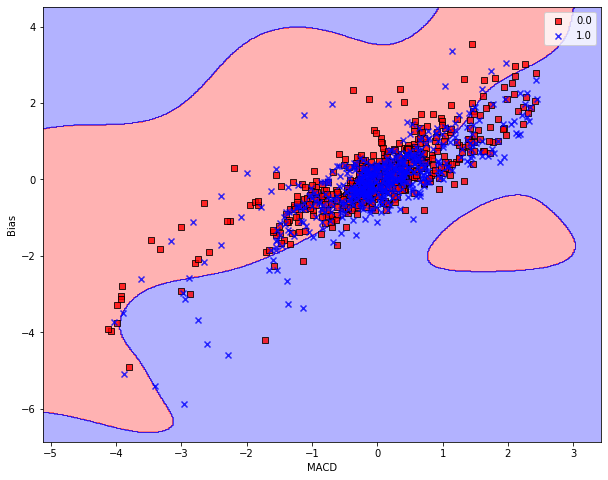

rbf score:
0.5226449275362319





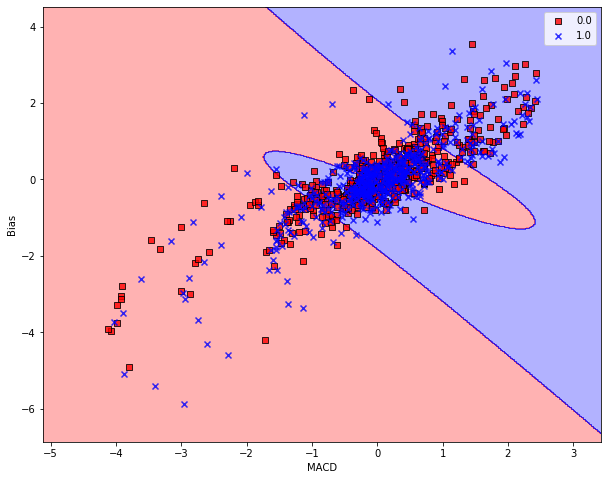

sigmoid score:
0.5





In [34]:
kind = ['linear', 'poly', 'rbf', 'sigmoid']
for ikind in kind:
    svm = SVC(kernel=ikind, C=1.0, random_state=seed)
    svm.fit(X_train_std, y_train)

    plot_decision_regions(np.array(X_test_std), np.array(y_test), svm)
    plt.xlabel('MACD')
    plt.ylabel('Bias')
    plt.legend(loc = 'upper right')
    plt.show()
    
    print(ikind + ' score:\n{}'.format(svm.score(X_test_std, y_test))+ '\n\n\n')

## MLPClassifier

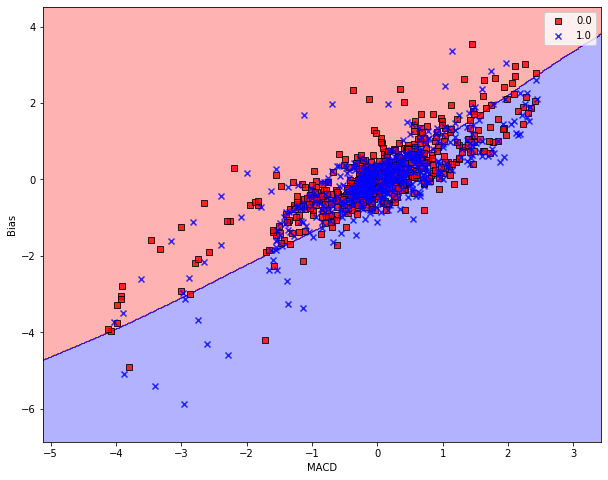

sgd score:
0.5335144927536232





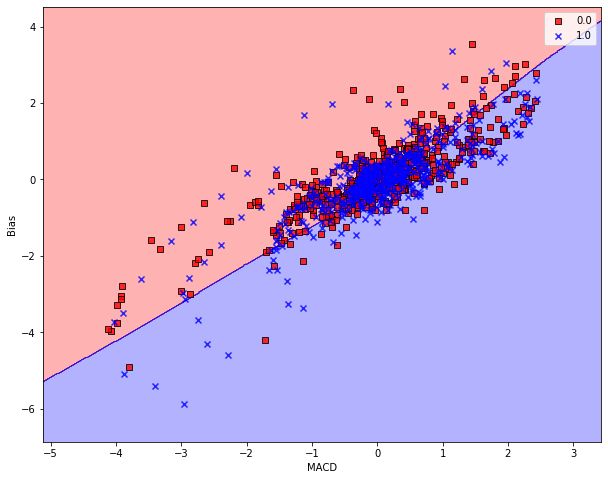

adam score:
0.5480072463768116





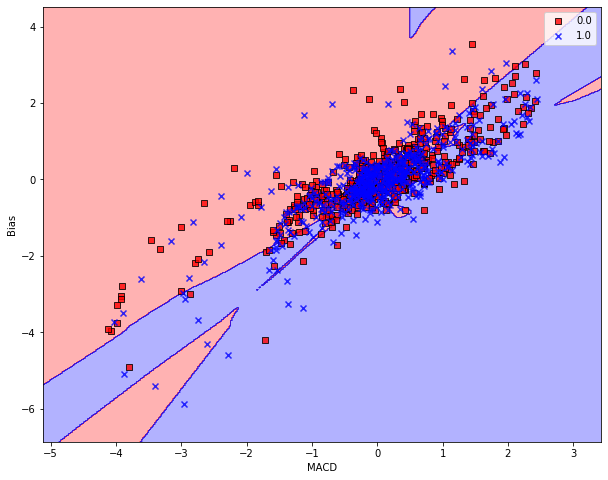

lbfgs score:
0.5353260869565217





In [36]:
kind = ['sgd', 'adam', 'lbfgs']
for ikind in kind:
    mlp = MLPClassifier(solver=ikind, random_state=seed)
    mlp.fit(X_train_std, y_train)
    
    plot_decision_regions(np.array(X_test_std), np.array(y_test), mlp)
    plt.xlabel('MACD')
    plt.ylabel('Bias')
    plt.legend(loc = 'upper right')
    plt.show()
    print(ikind + ' score:\n{}'.format(mlp.score(X_test_std, y_test))+ '\n\n\n')
 